Clone Repo

In [2]:
!git clone https://github.com/haifaashkar319/490-diabetes-prediction-neural-network.git


Cloning into '490-diabetes-prediction-neural-network'...


In [3]:
%cd 490-diabetes-prediction-neural-network

/content/490-diabetes-prediction-neural-network


Install libraries


In [4]:
!pip install torch torchvision torchaudio
!pip install pandas scikit-learn


Import libraries


In [51]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt



Load data

In [6]:
df = pd.read_csv('diabetes.csv')


Explore the Dataset: Use .head() to view the first few rows and understand the structure of your data.

In [7]:
print(df.head())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


Split the Data: Separate your features (inputs) from the target (output).

In [8]:
X = df.drop('Outcome', axis=1).values  # Features
y = df['Outcome'].values  # Target


Train-Test Split: Use Scikit-learn to split the dataset into training and testing sets.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Standardize the Data: Normalize the features using StandardScaler.



In [61]:
class DiabetesModel:
    def __init__(self, X, y, hidden_size=64, learning_rate=0.001, test_size=0.2, val_size=0.25, batch_size=32):
        input_size = X.shape[1]

        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

        # Standardize data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        # Convert to PyTorch tensors
        self.X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        self.y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
        self.X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        self.y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
        self.X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        self.y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

        # Set batch size
        self.batch_size = batch_size

        # Define the model architecture
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        # Define loss function and optimizer
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

    def train(self, num_epochs=100):
        # Prepare DataLoader for training and validation data
        train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        val_dataset = TensorDataset(self.X_val_tensor, self.y_val_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        # Store training and validation losses for visualization
        train_losses, val_losses = [], []

        for epoch in range(num_epochs):
            # Training phase
            self.model.train()
            running_train_loss = 0.0
            for inputs, targets in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                running_train_loss += loss.item() * inputs.size(0)

            # Average training loss for the epoch
            epoch_train_loss = running_train_loss / len(train_loader.dataset)
            train_losses.append(epoch_train_loss)

            # Validation phase
            self.model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets)
                    running_val_loss += loss.item() * inputs.size(0)

            # Average validation loss for the epoch
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}] '
                      f'Training Loss: {epoch_train_loss:.4f} '
                      f'Validation Loss: {epoch_val_loss:.4f}')

        # Plot training and validation losses and save the figure
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.savefig('training_validation_loss_plot.png')  # Save plot as a file
        plt.show()
        print("Plot saved as 'training_validation_loss_plot.png'")

    def evaluate(self):
        # Evaluate on the test data
        self.model.eval()
        with torch.no_grad():
            test_outputs = self.model(self.X_test_tensor)
            test_loss = self.criterion(test_outputs, self.y_test_tensor).item()
            test_mse = mean_squared_error(self.y_test_tensor.numpy(), test_outputs.numpy())

        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test MSE: {test_mse:.4f}")

    def predict(self, X):
        # Set model to evaluation mode for prediction
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X)
        return predictions


Epoch [1/100] Training Loss: 0.6207 Validation Loss: 0.4131
Epoch [10/100] Training Loss: 0.1642 Validation Loss: 0.1541
Epoch [20/100] Training Loss: 0.1462 Validation Loss: 0.1465
Epoch [30/100] Training Loss: 0.1382 Validation Loss: 0.1469
Epoch [40/100] Training Loss: 0.1329 Validation Loss: 0.1500
Epoch [50/100] Training Loss: 0.1291 Validation Loss: 0.1544
Epoch [60/100] Training Loss: 0.1256 Validation Loss: 0.1558
Epoch [70/100] Training Loss: 0.1225 Validation Loss: 0.1585
Epoch [80/100] Training Loss: 0.1199 Validation Loss: 0.1594
Epoch [90/100] Training Loss: 0.1167 Validation Loss: 0.1597
Epoch [100/100] Training Loss: 0.1131 Validation Loss: 0.1610


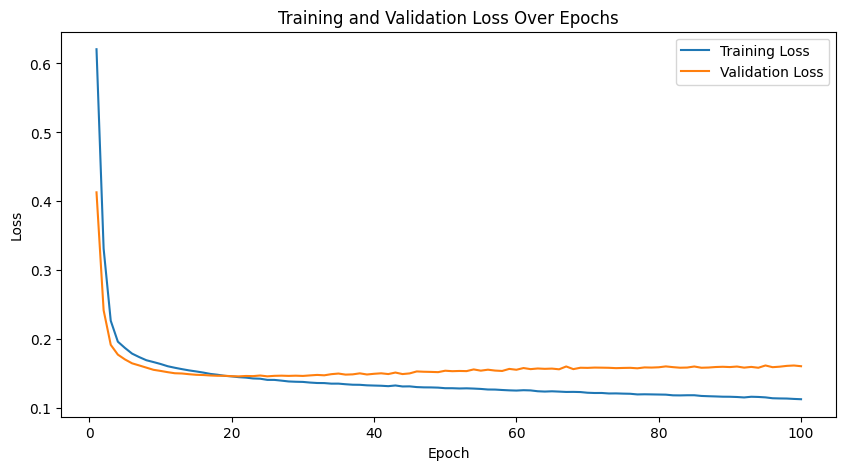

Plot saved as 'training_validation_loss_plot.png'
Test Loss: 0.1837
Test MSE: 0.1837


In [63]:
# Load the dataset
data = pd.read_csv('diabetes.csv')
X = data.drop('Outcome', axis=1).values  # Features
y = data['Outcome'].values  # Target

# Create and train the model
diabetes_model = DiabetesModel(X, y, hidden_size=64, learning_rate=0.001)  # Removed num_epochs
diabetes_model.train(num_epochs=100)  # Pass num_epochs to the train method

# Evaluate the model
diabetes_model.evaluate()


In [53]:
y_test_predictions = diabetes_model.model(diabetes_model.X_test_tensor).detach().numpy()
y_pred_binary = (y_test_predictions >= 0.5).astype(int)  # Convert to binary predictions


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc


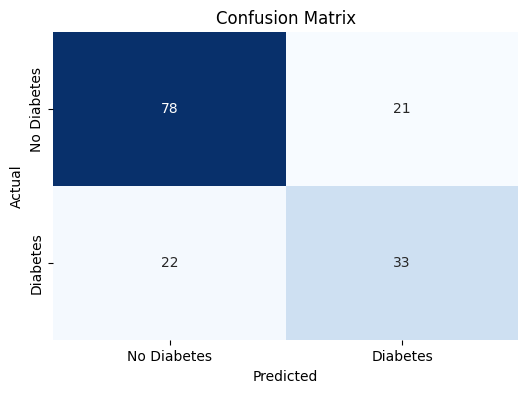

In [55]:
# Confusion Matrix
cm = confusion_matrix(diabetes_model.y_test_tensor.numpy(), y_pred_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
